## Doyle Reaction Prediction Pt. 4: Additive Importance in Random Forests

The one-hot experiments provided in the previous notebook gave better results on out-of-sample tests for new additives than expected, indicating that additives may be limited in their importance for predicting yield. This appears to be inconsistent with the paper's analysis on random forest feature importances, where additive features are most significant.

For categorical variables, it has been established that traditional random forests are biased toward categories with more 'levels' (e.g. if a categorical variable has 50 potential values, and another only has 10, then the system will be biased towards the former). Sensitivity in levels and scaling could, in part, be responsible for inflated additive importances.

Some useful background and analysis can be found in:

    1) https://www.tandfonline.com/doi/abs/10.1198/016214501753168271
    2) https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-8-25
    
Reading this paper, each substrate/ligand/additive/base we try are represented by discrete numerical values. One question is whether there is a natural bias towards any of the parameters. 

Our hypothesis is:

    Additive importances are biased in a traditional random forests implementation.

Design:
    
    To decorrelate input variables to the dependent variable (yield), we will shuffle the yields. We will fit a random forest regressor to this data, and extract out the feature importances. Unbiased feature importances should be evenly distributed across each parameter, and we would not expect enrichment for any specific set of features (e.g. no enrichment for additive features).

In [1]:
# Import our libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Import relevant scikit-learn modules

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score

# Load RPy2 Libraries for R dataframes
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects

import utils
# set a seed for all the randoms
np.random.seed(42)

In [2]:
# Define path and csv files
DATA_DIR = 'data/'
YIELDS_DF = 'yields.csv'
INPUTS = 'output_table.csv'      # Unscaled  data from github.com/doylelab/rxnpredict
TRAIN_DF = 'training_scaled.rds' # Scaled training data from github.com/doylelab/rxnpredict
TEST_DF = 'test_scaled.rds'      # Scaled test set data from github.com/doylelab/rxnpredict

In [3]:
# Load yields data
yields = pd.read_csv(DATA_DIR + YIELDS_DF)

# As in the paper, remove controls and additive 7
yields = np.array(yields['x'])
yields = yields.reshape(3 * 32, 48)
yields = np.delete(yields, [0, 4, 8, 12, 19, 23, 27, 31], axis=0)
yields = np.delete(yields, [15, 31, 47], axis=1)
yields = yields.flatten()

# it turns out the yield data contains some NaNs
# we set these to zeroes
y_set = yields

for idx, value in enumerate(y_set):
    if np.isfinite(value) == False:
        print(idx, value)
        y_set[idx] = np.nanmean(y_set)

696 nan
741 nan
796 nan
797 nan
884 nan


In [4]:
# Activate RPy2
pandas2ri.activate()
readRDS = robjects.r['readRDS']

# load R dataframes
train_rds = readRDS(DATA_DIR + TRAIN_DF)
test_rds  = readRDS(DATA_DIR + TEST_DF)

# convert these to pandas dataframes
train_df = pandas2ri.ri2py(train_rds)
test_df  = pandas2ri.ri2py(test_rds)

train_indices = train_df.sort_index().index - 1
test_indices = test_df.sort_index().index - 1

In [5]:
# Load chemical features and standard scales
inputs = pd.read_csv(DATA_DIR + INPUTS)
features = inputs.columns

scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)

In [6]:
# shuffle the yields
y_set = yields
np.random.shuffle(y_set)

In [7]:
X_train = inputs[train_indices]
y_train = y_set[train_indices]

X_test = inputs[test_indices]
y_test = y_set[test_indices]

In [8]:
models = [LinearRegression(), # use default
          KNeighborsRegressor(n_neighbors=7), # use k = 7 as in paper
          MLPRegressor(hidden_layer_sizes=(5),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          MLPRegressor(hidden_layer_sizes=(100),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          RandomForestRegressor(n_estimators=500,
                                random_state=42)
         ]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=Tr

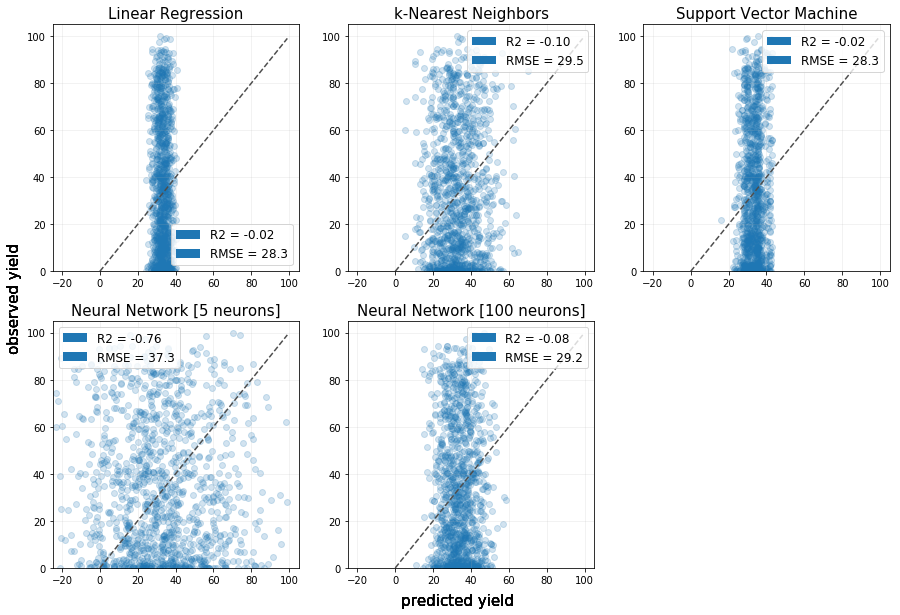

In [9]:
preds, r2_values, rmse_values = utils.fit_models(X_train,
                                                           X_test,
                                                           y_train,
                                                           y_test,
                                                           models)

utils.plot_models(preds,
                  r2_values,
                  rmse_values,
                  y_test)

As expected, shuffling the yields destroys any ability to predict. We will conduct 100 trials of this random experiment, and take the average feature importances.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
results = []
for i in range(100): # shuffle 100 times
    np.random.shuffle(y_set)
    X_train, X_test, y_train, y_test = train_test_split(inputs, y_set, test_size=0.30)
    model = RandomForestRegressor(n_estimators=500,
                                  n_jobs=-1)
    model.fit(X_train, y_train)
    new_df = pd.DataFrame()
    new_df['importances'] = model.feature_importances_
    new_df['features'] = features
    new_df = new_df.sort_values(by=['importances'], ascending=False)
    results.append(new_df)

In [12]:
fracs = []
for result in results:
    top_ten = result['features'][:10]
    no_add_feats = top_ten.str.startswith('additive').sum()
    fraction = no_add_feats / 10
    fracs.append(fraction)

fracs = np.array(fracs)
mean_fracs = fracs.mean()

Out of 100 random shuffles and samplings, on average 8.5 out of 10 of the most important features for random forests are additive based.

In [13]:
halides = []
additives = []
bases = []
ligands = []
for result in results:
    halide = result[result['features'].str.startswith('aryl')]['importances']
    additive = result[result['features'].str.startswith('additive')]['importances']
    base = result[result['features'].str.startswith('base')]['importances']
    ligand = result[result['features'].str.startswith('ligand')]['importances']
    halides.append(halide)
    additives.append(additive)
    bases.append(base)
    ligands.append(ligand)

In [14]:
halides = pd.concat(halides)
additives = pd.concat(additives)
bases = pd.concat(bases)
ligands = pd.concat(ligands)

In [15]:
halide_stats = halides.mean(), halides.std()
additive_stats = additives.mean(), additives.std()
base_stats = bases.mean(), bases.std()
ligand_stats = ligands.mean(), ligands.std()

print(halide_stats,
      additive_stats,
      base_stats,
      ligand_stats)

(0.011424145028970701, 0.0024950368109492695) (0.017784262976952313, 0.00364298039527452) (0.015703984345568994, 0.003469032434464032) (0.0030719881906251132, 0.0002777429342948545)


/home/kangway/.conda/envs/doyle_rxn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


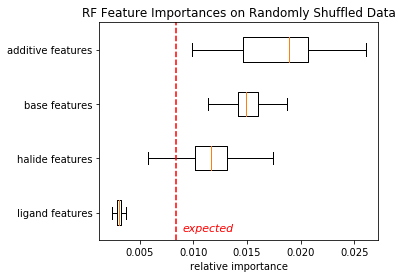

In [16]:
plt.figure(figsize=(5,4))
plt.tight_layout()
plt.title('RF Feature Importances on Randomly Shuffled Data')
plt.xlabel('relative importance')
labels = ['ligand features',
          'halide features',
          'base features',
          'additive features']
plt.boxplot([ligands, halides, bases, additives],
            0, '', 0, labels=labels)
plt.axvline(x=1/120, ls="--", c='r')
plt.text(0.009, 0.65, 'expected', fontsize=11, color='r', style='italic')
plt.savefig('plots/boxplot_featureimportances.png', dpi = 300, bbox_inches='tight')
plt.show()

additive features are consistently elevated compared to base and halide features.

In [17]:
sample_importances = results[3][:10].sort_values(by=['importances'], ascending=True)

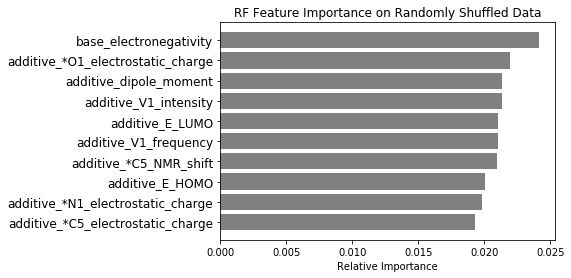

In [18]:
plt.title('RF Feature Importance on Randomly Shuffled Data')
plt.barh(range(10), sample_importances['importances'], color='gray', align='center')
plt.yticks(range(10), sample_importances['features'], fontsize=12)
plt.xlabel('Relative Importance')
plt.savefig('plots/topten_feature_importances.png', dpi = 300,bbox_inches='tight')
plt.show()

In [19]:
fracs = []
for result in results:
    top_ten = result['features'][:10]
    no_add_feats = top_ten.str.startswith('additive').sum()
    fraction = no_add_feats / 10
    fracs.append(fraction)

fracs = np.array(fracs)
mean_fracs = fracs.mean()

In [20]:
mean_fracs

0.8540000000000001

Out of 100 random shuffles and samplings, on average 8.5 out of 10 of the most important features for random forests are additive based.

Conclusion:

    Running a random baseline, there appears to be a strong bias towards additive features, with aryl halide features coming in second.